In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [3]:
#loading data
big_mart_data=pd.read_csv('/kaggle/input/bigmart-sales-data/Train.csv')
big_mart_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


# understanding and cleaning data

In [4]:
big_mart_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [5]:
#getting info about null value and data type
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


We have missing value in Item_Weight and outlet_Size  
so we have to fill it.

In [6]:
#filling missing value of Item weight by mean 
Item_Weight_mean=big_mart_data['Item_Weight'].mean()
big_mart_data['Item_Weight'].fillna(Item_Weight_mean,inplace=True)

So next we are filling missing values of Outlet_Size  
 


In [7]:
for a in range(big_mart_data.shape[0]):
    if pd.isna(big_mart_data.iloc[a]['Outlet_Size']):# pd.isna() is for checking is the value na or not
        
        # big_mart_data[big_mart_data['Outlet_Type']==big_mart_data.iloc[a]['Outlet_Type']]['Outlet_Size'].mode()[0]
        # the above line is taking out data whose Outlet_Type is same as the outlet type of the data at 'a' and then finding the
        # mode of Outlet_Size of that data
        
        big_mart_data.at[a, 'Outlet_Size']=big_mart_data[big_mart_data['Outlet_Type']==big_mart_data.iloc[a]['Outlet_Type']]['Outlet_Size'].mode()[0]

In [8]:
big_mart_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Small,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [9]:
#checking for null data
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [10]:
big_mart_data.duplicated().sum()

0

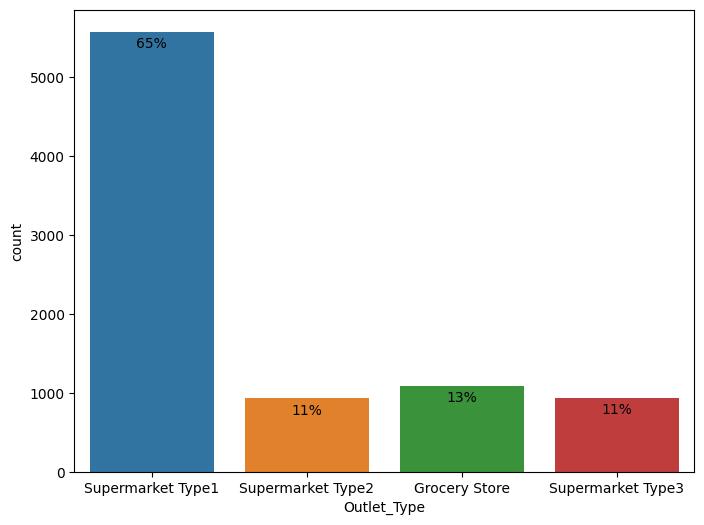

In [11]:
#count of value in outlet type
plt.figure(figsize=(8,6))
sns.countplot(data=big_mart_data,x='Outlet_Type')
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'{round(p.get_height()*100/big_mart_data.shape[0])}%',(p.get_x()-0.1+p.get_width()/2,p.get_height()-200))

Findings from the chart:  
In respect to counts of stores  
**Supermarket Type1> Grocery Store>Supermarket Type2 and Supermarket Type3**

In [12]:
#data cleaning
big_mart_data['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)

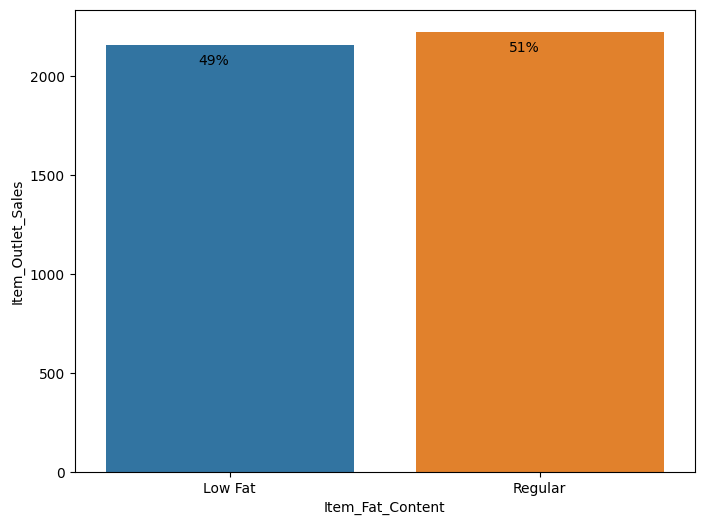

In [13]:
big_mart_data_grouped_Item_Fat_Content=big_mart_data[['Item_Fat_Content','Item_Outlet_Sales']].groupby(by='Item_Fat_Content').mean().reset_index()
plt.figure(figsize=(8,6))
sns.barplot(data=big_mart_data_grouped_Item_Fat_Content,y='Item_Outlet_Sales',x='Item_Fat_Content')
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'{round(p.get_height()*100/big_mart_data_grouped_Item_Fat_Content["Item_Outlet_Sales"].sum())}%',(p.get_x()-0.1+p.get_width()/2,p.get_height()-100))

Findings of the graph:  
Low fat and Regular are **almost same**

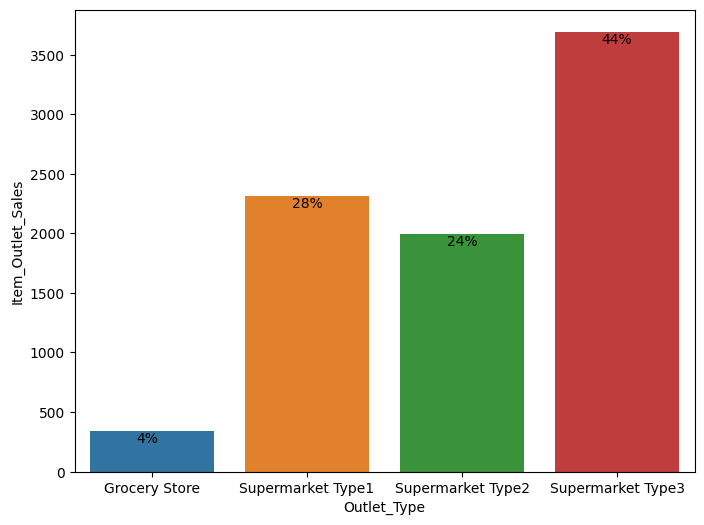

In [14]:
big_mart_data_grouped_Outlet_Type=big_mart_data[['Outlet_Type','Item_Outlet_Sales']].groupby(by='Outlet_Type').mean().reset_index()
plt.figure(figsize=(8,6))
sns.barplot(data=big_mart_data_grouped_Outlet_Type,y='Item_Outlet_Sales',x='Outlet_Type')
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'{round(p.get_height()*100/big_mart_data_grouped_Outlet_Type["Item_Outlet_Sales"].sum())}%',(p.get_x()-0.1+p.get_width()/2,p.get_height()-100))

Findings from the chart:  
In respect of item output sales  
**Supermarket Type3> Supermarket Type1> Supermarket Type2> Grocery Store**

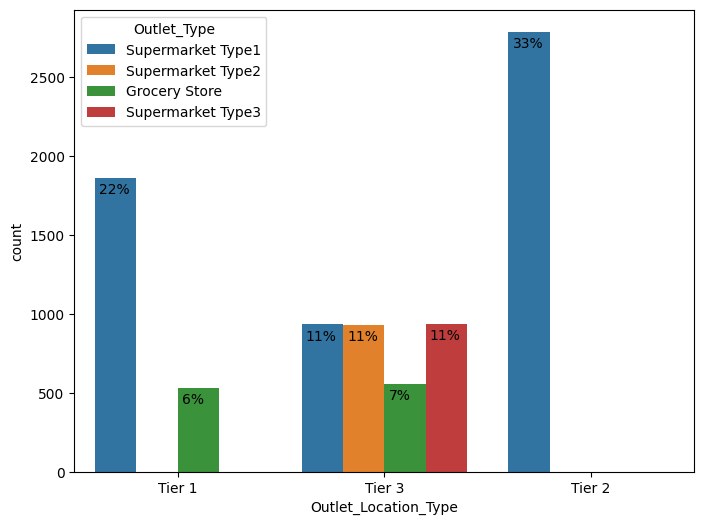

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(data=big_mart_data,x='Outlet_Location_Type',hue='Outlet_Type')
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'{round(p.get_height()*100/big_mart_data.shape[0])}%',(p.get_x()-0.08+p.get_width()/2,p.get_height()-100))

Findings from the chart:  
1. Tier 1 only have Superarket Type1 and Grocery Store.  
2. Tier 2 only has Superarket Type1.  
3. Tier 3 has most number of stores(40%).

<Axes: >

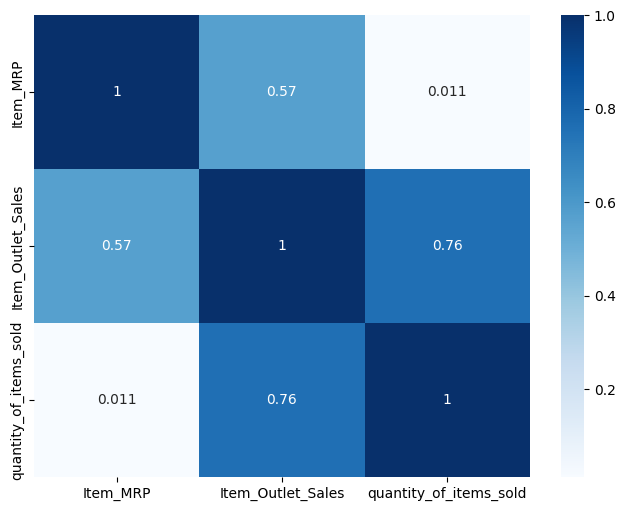

In [16]:
big_mart_data_sub=big_mart_data.loc[:,['Item_MRP','Item_Outlet_Sales']]
big_mart_data_sub['quantity_of_items_sold']=round(big_mart_data_sub['Item_Outlet_Sales']/big_mart_data_sub['Item_MRP'])
plt.figure(figsize=(8,6))
sns.heatmap(big_mart_data_sub.corr(),cmap='Blues',annot=True)

Findings from the map:  
1. **No** correlation between **Item_MRP and quantity_of_items_sold**.  
2. **Good** correlation between **Item_MRP and Item_outlet_sales**.  
3. **Good** correlation between **quantity_of_items_sold and Item_outlet_sales**.

In [17]:
#getting statistical information of the data    '.T' is for transposing (changing row into column and vice versa) 
big_mart_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,8523.0,12.857645,4.226124,4.555,9.310000,12.857645,16.000000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [18]:
#checking object column 
object_column=[column for column in big_mart_data.columns if big_mart_data[column].dtype=='object']

<Axes: >

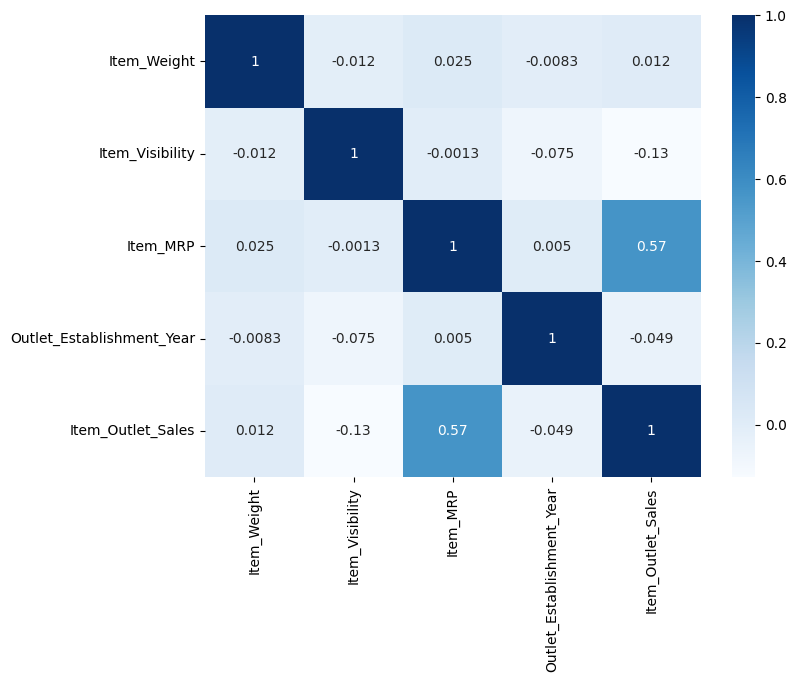

In [19]:
#plotting heat map
big_mart_data_corr=big_mart_data.drop(object_column,axis=1).corr()
plt.figure(figsize=(8,6))
sns.heatmap(big_mart_data_corr,cmap='Blues',annot=True)

In [20]:
#labeling all object columns
for column in big_mart_data.columns:
    if(big_mart_data[column].dtype=='object'):
        encoder=LabelEncoder() 
        big_mart_data[column]=encoder.fit_transform(big_mart_data[column])

big_mart_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.300,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.920,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.500,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.200,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.930,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,370,6.865,0,0.056783,13,214.5218,1,1987,0,2,1,2778.3834
8519,897,8.380,1,0.046982,0,108.1570,7,2002,2,1,1,549.2850
8520,1357,10.600,0,0.035186,8,85.1224,6,2004,2,1,1,1193.1136
8521,681,7.210,1,0.145221,13,103.1332,3,2009,1,2,2,1845.5976


# data preprocessing

In [21]:
X=big_mart_data.iloc[:,:-1]
y=big_mart_data.iloc[:,-1]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

In [24]:
print(X.shape, X_train.shape, X_cv.shape,X_test.shape)

(8523, 11) (5113, 11) (1705, 11) (1705, 11)


# machine learning model

In [25]:
#regressor fitting
regressor=XGBRegressor()
regressor.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [27]:
#prediction and error assement with mean_squared_error
print(metrics.mean_squared_error(regressor.predict(X_train),y_train),metrics.mean_squared_error(regressor.predict(X_cv),y_cv))

331438.16130731395 1414682.6115671047


In [28]:
from xgboost import XGBRegressor
import joblib

joblib.dump(regressor, 'xgb_regressor_model.joblib')


loaded_regressor = joblib.load('xgb_regressor_model.joblib')




In [29]:
#prediction and error assement with mean_squared_error
print(metrics.mean_squared_error(loaded_regressor.predict(X_train),y_train),metrics.mean_squared_error(loaded_regressor.predict(X_cv),y_cv))

331438.16130731395 1414682.6115671047


# Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid={
    'alpha': [0.01, 0.1, 1.0],  
    'lambda': [0.01, 0.1, 1.0], 
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
model=XGBRegressor(objective='reg:squarederror')
grid_search=GridSearchCV(model,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)
best_params=grid_search.best_params_
best_regressor=XGBRegressor(objective='reg:squarederror',**best_params)
best_regressor.fit(X_train,y_train)

In [ ]:
print(metrics.mean_squared_error(best_regressor.predict(X_train),y_train),metrics.mean_squared_error(best_regressor.predict(X_cv),y_cv))

In [ ]:
prediction=best_regressor.predict(X_test)

In [ ]:
metrics.mean_squared_error(prediction,y_test)